In [1]:
using QuantEcon
using BasisMatrices
using ContinuousDPs
using LinearAlgebra

In [2]:
# https://discourse.julialang.org/t/accents-and-greek-letters/37954
ENV["GKS_ENCODING"]="utf-8"
using Plots
import PyPlot

## Optimal Economic Growth

In [3]:
n = 10
s_min, s_max = 5, 10
basis = Basis(ChebParams(n, s_min, s_max))

1 dimensional Basis on the hypercube formed by (5.0,) × (10.0,).
Basis families are Cheb


In [4]:
alpha = 0.2
bet = 0.5
gamm = 0.9
sigma = 0.1
discount = 0.9;

In [5]:
x_star = ((discount * bet) / (1 - discount * gamm))^(1 / (1 - bet))
s_star = gamm * x_star + x_star^bet
s_star, x_star

(7.416897506925212, 5.6094182825484795)

In [6]:
f(s, x) = (s - x)^(1 - alpha) / (1 - alpha)
g(s, x, e) = gamm * x .+ e * x^bet;

In [7]:
n_shocks = 3
shocks, weights = qnwlogn(n_shocks, -sigma^2/2, sigma^2)  # See Errata

([0.8367708003019956, 0.9950124791926823, 1.1831792330610165], [0.16666666666666674, 0.6666666666666666, 0.16666666666666674])

In [8]:
x_lb(s) = 0
x_ub(s) = 0.99 * s;

In [9]:
cdp = ContinuousDP(f, g, discount, shocks, weights, x_lb, x_ub, basis)

ContinuousDP{1,Array{Float64,1},Array{Float64,1},typeof(f),typeof(g),typeof(x_lb),typeof(x_ub)}(f, g, 0.9, [0.8367708003019956, 0.9950124791926823, 1.1831792330610165], [0.16666666666666674, 0.6666666666666666, 0.16666666666666674], x_lb, x_ub, ContinuousDPs.Interp{1,Array{Float64,1},Array{Float64,2},LU{Float64,Array{Float64,2}}}(1 dimensional Basis on the hypercube formed by (5.0,) × (10.0,).
Basis families are Cheb
, [5.030779148512155, 5.27248368952908, 5.732233047033631, 6.365023750651133, 7.108913837399423, 7.891086162600577, 8.634976249348867, 9.267766952966369, 9.72751631047092, 9.969220851487844], ([5.030779148512155, 5.27248368952908, 5.732233047033631, 6.365023750651133, 7.108913837399423, 7.891086162600577, 8.634976249348867, 9.267766952966369, 9.72751631047092, 9.969220851487844],), 10, (10,), (5.0,), (10.0,), [1.0 -0.9876883405951379 … 0.30901699437495467 -0.1564344650402394; 1.0 -0.8910065241883679 … -0.8090169943749478 0.4539904997395474; … ; 1.0 0.8910065241883679 … -0.

### Value iteration

In [10]:
res = solve(cdp, VFI);

Compute iterate 50 with error 0.00856936646624007
Compute iterate 100 with error 4.4164588469897126e-5
Compute iterate 150 with error 2.2761436113682976e-7
Compute iterate 176 with error 1.470635169198431e-8
Converged in 176 steps


In [11]:
s_min, s_max = cdp.interp.lb[1], cdp.interp.ub[1]
grid_length = 500
s_nodes = range(s_min, stop=s_max, length=grid_length)
set_eval_nodes!(res, s_nodes)
V, X, resid = res.V, res.X, res.resid;

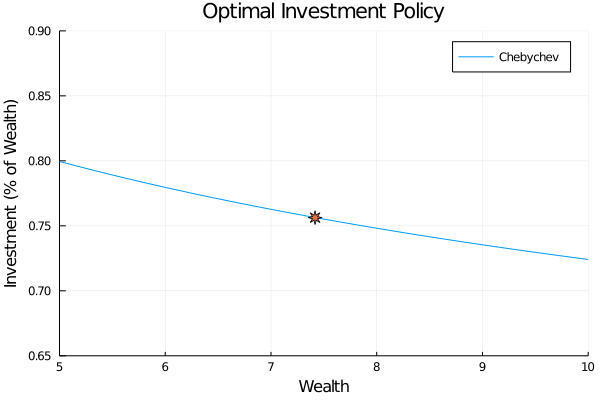

In [12]:
title = "Optimal Investment Policy"
xlabel = "Wealth"
ylabel = "Investment (% of Wealth)"
plot(s_nodes, X./s_nodes, xlims=(s_min, s_max), ylims=(0.65, 0.9),
     title=title, xlabel=xlabel, ylabel=ylabel, label="Chebychev")
plot!([s_star], [x_star/s_star], m=(7,:star8), label="")

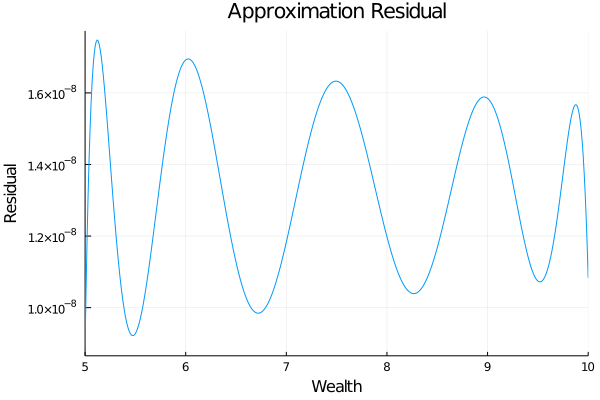

In [13]:
title = "Approximation Residual"
ylabel = "Residual"
plot(s_nodes, resid, xlims=(s_min, s_max), yformatter=:scientific,
     title=title, xlabel=xlabel, ylabel=ylabel, label="")

### Policy iteration

In [14]:
res = solve(cdp, PFI);

Compute iterate 6 with error 7.105427357601002e-15
Converged in 6 steps


In [15]:
set_eval_nodes!(res, s_nodes)
V, X, resid = res.V, res.X, res.resid;

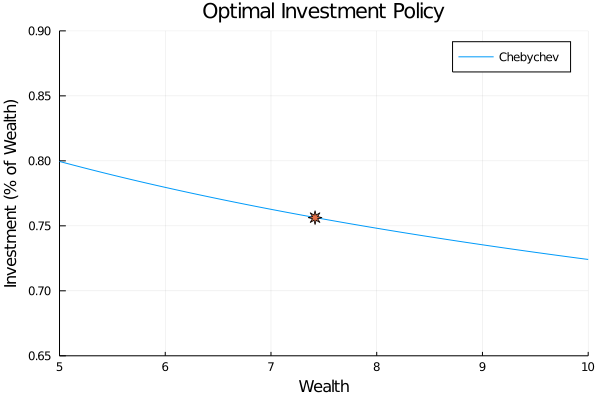

In [16]:
title = "Optimal Investment Policy"
xlabel = "Wealth"
ylabel = "Investment (% of Wealth)"
plot(s_nodes, X./s_nodes, xlims=(s_min, s_max), ylims=(0.65, 0.9),
     title=title, xlabel=xlabel, ylabel=ylabel, label="Chebychev")
plot!([s_star], [x_star/s_star], m=(7,:star8), label="")

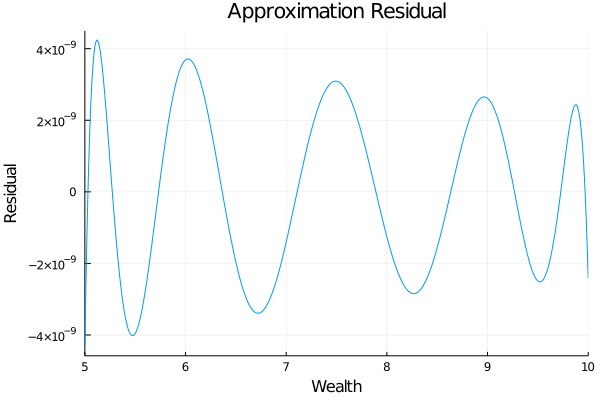

In [17]:
title = "Approximation Residual"
ylabel = "Residual"
plot(s_nodes, resid, xlims=(s_min, s_max), yformatter=:scientific,
     title=title, xlabel=xlabel, ylabel=ylabel, label="")

### Simulation

In [18]:
n_yrs = 20
n_paths = 2000
s_paths = Array{Float64}(undef, n_yrs+1, n_paths)
s_init = 5.
for i in 1:n_paths
    s_paths[:, i] = simulate(res, s_init, n_yrs+1)
end
mean_s_path = mean(s_paths, dims=2);

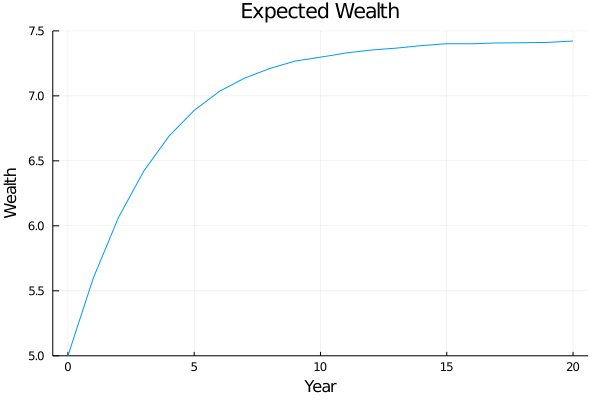

In [19]:
title = "Expected Wealth"
xlabel = "Year"
ylabel = "Wealth"
plot(0:n_yrs, mean_s_path, ylims=(5, 7.5),
     title=title, xlabel=xlabel, ylabel=ylabel, label="")

## Nonrenewable Resource Management

In [20]:
k = 3
m = 101
breaks = m - (k-1)
s_min, s_max = 0, 10
basis = Basis(SplineParams(breaks, s_min, s_max, k))

1 dimensional Basis on the hypercube formed by (0.0,) × (10.0,).
Basis families are Spline


In [21]:
a = [10, 0.8]
b = [12, 1.0]
discount = 0.9;

In [22]:
p(x) = a[1] - a[2] * x / 2
c(s, x) = b[1] * x - b[2] * x * (2*s - x) / 2
f(s, x) = p(x) * x - c(s, x)
g(s, x, e) = s - x;

In [23]:
shocks, weights = [0.], [1.];

In [24]:
x_lb(s) = 0
x_ub(s) = s;

In [25]:
cdp = ContinuousDP(f, g, discount, shocks, weights, x_lb, x_ub, basis)

ContinuousDP{1,Array{Float64,1},Array{Float64,1},typeof(f),typeof(g),typeof(x_lb),typeof(x_ub)}(f, g, 0.9, [0.0], [1.0], x_lb, x_ub, ContinuousDPs.Interp{1,Array{Float64,1},SparseArrays.SparseMatrixCSC{Float64,Int64},SuiteSparse.UMFPACK.UmfpackLU{Float64,Int64}}(1 dimensional Basis on the hypercube formed by (0.0,) × (10.0,).
Basis families are Spline
, [0.0, 0.034013605442176874, 0.10204081632653061, 0.20408163265306123, 0.30612244897959184, 0.40816326530612246, 0.5102040816326532, 0.6122448979591838, 0.7142857142857144, 0.8163265306122449  …  9.18367346938775, 9.285714285714297, 9.387755102040822, 9.48979591836735, 9.591836734693876, 9.693877551020401, 9.795918367346948, 9.897959183673473, 9.96598639455783, 10.0], ([0.0, 0.034013605442176874, 0.10204081632653061, 0.20408163265306123, 0.30612244897959184, 0.40816326530612246, 0.5102040816326532, 0.6122448979591838, 0.7142857142857144, 0.8163265306122449  …  9.18367346938775, 9.285714285714297, 9.387755102040822, 9.48979591836735, 9.59

### Value iteration

In [26]:
res = solve(cdp, VFI);

Compute iterate 38 with error 1.4533888759160618e-8
Converged in 38 steps


In [27]:
s_min, s_max = cdp.interp.lb[1], cdp.interp.ub[1]
grid_length = 500
s_nodes = range(s_min, stop=s_max, length=grid_length)
set_eval_nodes!(res, s_nodes)
V, X, resid = res.V, res.X, res.resid;

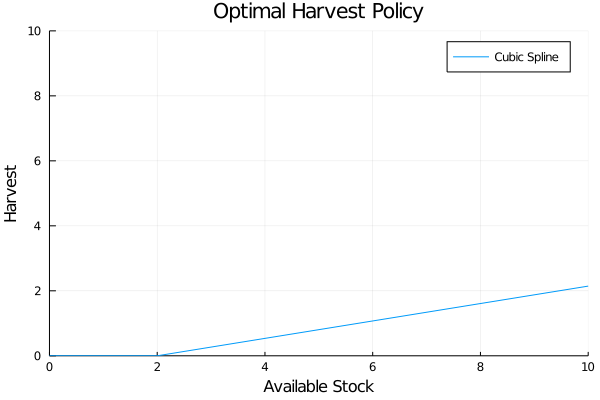

In [28]:
title = "Optimal Harvest Policy"
xlabel = "Available Stock"
ylabel = "Harvest"
plot(s_nodes, X, xlims=(s_min, s_max), ylims=(0, 10),
     title=title, xlabel=xlabel, ylabel=ylabel, label="Cubic Spline")

In [29]:
B1 = evalbase(cdp.interp.basis.params[1], s_nodes, 1)
shadow_prices = B1 * res.C;

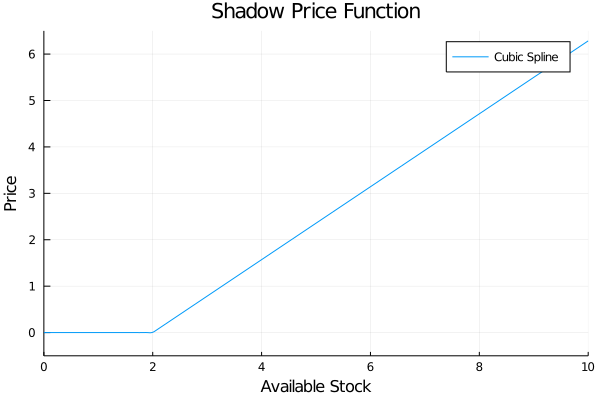

In [30]:
title = "Shadow Price Function"
ylabel = "Price"
plot(s_nodes, shadow_prices, xlims=(s_min, s_max), ylims=(-0.5, 6.5),
     title=title, xlabel=xlabel, ylabel=ylabel, label="Cubic Spline")

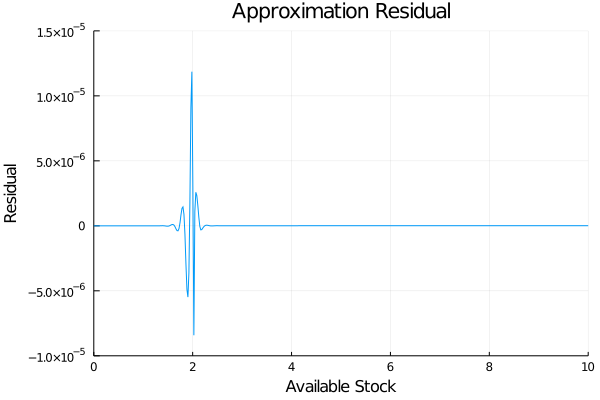

In [31]:
title = "Approximation Residual"
ylabel = "Residual"
plot(s_nodes, resid, xlims=(s_min, s_max), ylims=(-1e-5, 1.5e-5), yformatter=:scientific,
     title=title, xlabel=xlabel, ylabel=ylabel, label="")

### Policy iteration

In [32]:
res = solve(cdp, PFI);

Compute iterate 6 with error 3.705813867577179e-14
Converged in 6 steps


In [33]:
set_eval_nodes!(res, s_nodes)
V, X, resid = res.V, res.X, res.resid;

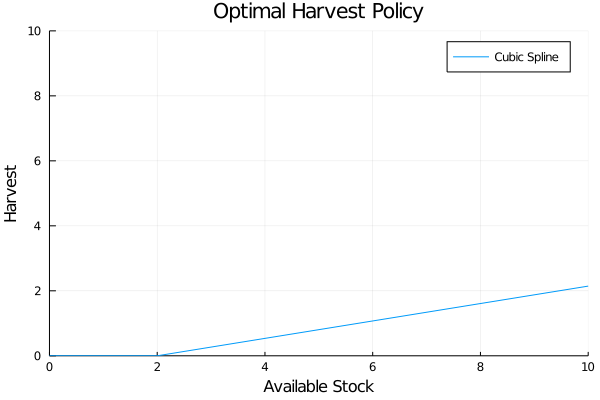

In [34]:
title = "Optimal Harvest Policy"
xlabel = "Available Stock"
ylabel = "Harvest"
plot(s_nodes, X, xlims=(s_min, s_max), ylims=(0, 10),
     title=title, xlabel=xlabel, ylabel=ylabel, label="Cubic Spline")

In [35]:
B1 = evalbase(cdp.interp.basis.params[1], s_nodes, 1)
shadow_prices = B1 * res.C;

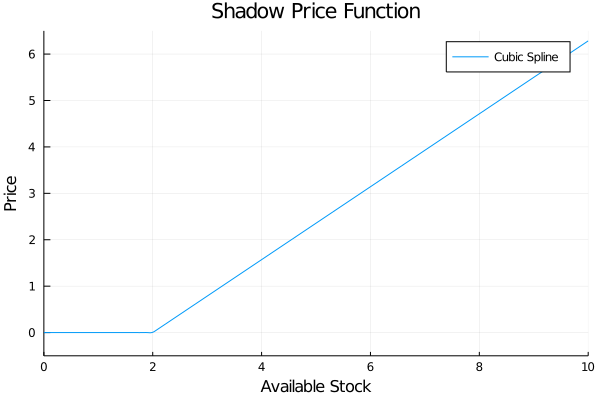

In [36]:
title = "Shadow Price Function"
ylabel = "Price"
plot(s_nodes, shadow_prices, xlims=(s_min, s_max), ylims=(-0.5, 6.5),
     title=title, xlabel=xlabel, ylabel=ylabel, label="Cubic Spline")

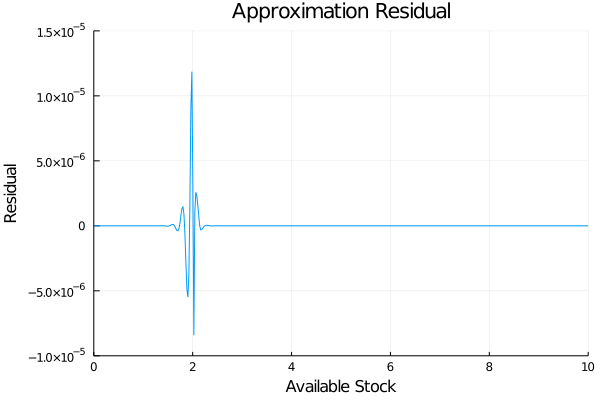

In [37]:
title = "Approximation Residual"
ylabel = "Residual"
plot(s_nodes, resid, xlims=(s_min, s_max), ylims=(-1e-5, 1.5e-5), yformatter=:scientific,
     title=title, xlabel=xlabel, ylabel=ylabel, label="")

### Simulation

In [38]:
n_yrs = 20
s_init = 10.
s_path = simulate(res, s_init, n_yrs+1);

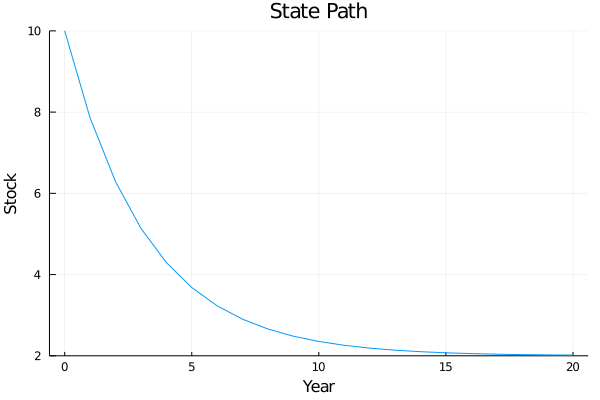

In [39]:
title = "State Path"
xlabel = "Year"
ylabel = "Stock"
plot(0:n_yrs, s_path, ylims=(2, 10),
     title=title, xlabel=xlabel, ylabel=ylabel, label="")

## Monetary Policy

In [40]:
bet = [0.8 0.5; 0.2 0.6]
gamm = [-0.8, 0.0]
Omega = [0.3 0.0; 0.0 1.0]
s_target = [0., 1.]
alpha = [0.9, 0.4]
Sigma = 0.04 * Matrix(I, 2, 2)
discount = 0.9;

In [41]:
f(s::Vector{Float64}, x::Float64) =
    -(s - s_target)' * Omega * (s - s_target) / 2
g(s::Vector{Float64}, x::Float64, e::Vector{Float64}) =
    alpha + bet * s + gamm * x + e
x_lb(s) = 0.
x_ub(s) = 100;

In [42]:
n_shocks = [3, 3]
mu = [0, 0]
shocks, weights = qnwnorm(n_shocks, mu, Sigma)

([-0.34641016151377546 -0.34641016151377546; 0.0 -0.34641016151377546; … ; 0.0 0.34641016151377546; 0.34641016151377546 0.34641016151377546], [0.027777777777777804, 0.11111111111111116, 0.027777777777777804, 0.11111111111111116, 0.4444444444444444, 0.11111111111111116, 0.027777777777777804, 0.11111111111111116, 0.027777777777777804])

In [43]:
k = [3, 3]
m = [10, 10]
breaks = m - (k.-1)
s_min = [-15, -10]
s_max = [15, 10]
basis = Basis(map(SplineParams, breaks, s_min, s_max, k)...)

2 dimensional Basis on the hypercube formed by (-15.0, -10.0) × (15.0, 10.0).
Basis families are Spline × Spline


In [44]:
cdp = ContinuousDP(f, g, discount, shocks, weights, x_lb, x_ub, basis)

ContinuousDP{2,Array{Float64,2},Array{Float64,2},typeof(f),typeof(g),typeof(x_lb),typeof(x_ub)}(f, g, 0.9, [-0.34641016151377546 -0.34641016151377546; 0.0 -0.34641016151377546; … ; 0.0 0.34641016151377546; 0.34641016151377546 0.34641016151377546], [0.027777777777777804, 0.11111111111111116, 0.027777777777777804, 0.11111111111111116, 0.4444444444444444, 0.11111111111111116, 0.027777777777777804, 0.11111111111111116, 0.027777777777777804], x_lb, x_ub, ContinuousDPs.Interp{2,Array{Float64,2},SparseArrays.SparseMatrixCSC{Float64,Int64},SuiteSparse.UMFPACK.UmfpackLU{Float64,Int64}}(2 dimensional Basis on the hypercube formed by (-15.0, -10.0) × (15.0, 10.0).
Basis families are Spline × Spline
, [-15.0 -10.0; -13.571428571428575 -10.0; … ; 13.571428571428575 10.0; 15.0 10.0], ([-15.0, -13.571428571428575, -10.714285714285714, -6.428571428571431, -2.142857142857139, 2.142857142857139, 6.428571428571431, 10.714285714285714, 13.571428571428575, 15.0], [-10.0, -9.04761904761905, -7.1428571428571

### Value iteration

In [45]:
res = solve(cdp, VFI);

Compute iterate 50 with error 0.0008238938359568238
Compute iterate 100 with error 3.3191218449246662e-6
Compute iterate 150 with error 1.710407104837941e-8
Compute iterate 152 with error 1.385467385262018e-8
Converged in 152 steps


In [46]:
s_min, s_max = cdp.interp.lb, cdp.interp.ub
grid_length = collect(cdp.interp.size) * 5
grids = [range(s_min[i], stop=s_max[i], length=grid_length[i]) for i in 1:2]
set_eval_nodes!(res, grids...)
V, X, resid = res.V, res.X, res.resid;

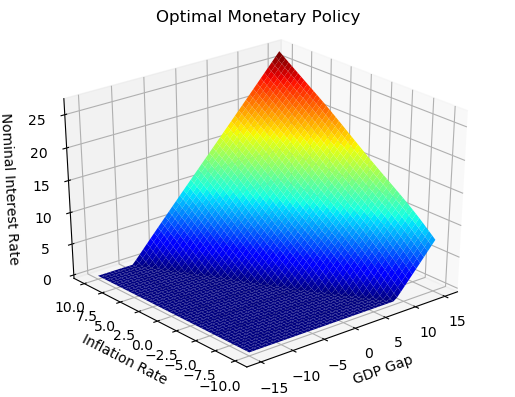

In [47]:
title = "Optimal Monetary Policy"
xlabel = "GDP Gap"
ylabel = "Inflation Rate"
zlabel = "Nominal Interest Rate"
PyPlot.surf(grids..., permutedims(reshape(X, grid_length...)), cmap=PyPlot.cm.jet)
ax = PyPlot.gca()
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.set_zlabel(zlabel)
ax.set_title(title, y=1.05)
ax.view_init(ax.elev, 230)

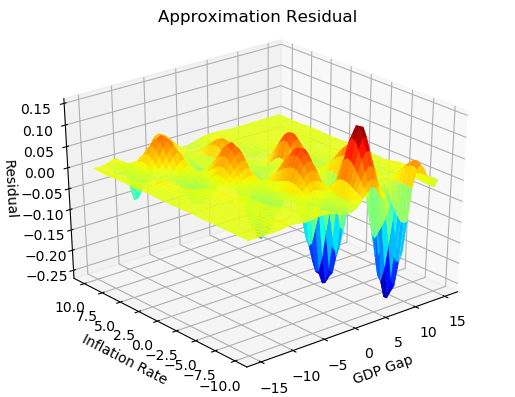

In [48]:
title = "Approximation Residual"
zlabel = "Residual"
PyPlot.surf(grids..., permutedims(reshape(resid, grid_length...)), cmap=PyPlot.cm.jet)
ax = PyPlot.gca()
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.set_zlabel(zlabel)
ax.set_title(title, y=1.05)
ax.view_init(ax.elev, 230)

### Policy iteration

In [49]:
res = solve(cdp, PFI);

Compute iterate 50 with error 1.0468130955686085e8
Compute iterate 100 with error 330201.65403946454
Compute iterate 150 with error 1.3044130872049485e6
Compute iterate 200 with error 5.269581038191973e-6
Compute iterate 250 with error 2.7024245810025604e-6
Compute iterate 300 with error 2.1262948962430528e-5
Compute iterate 350 with error 6.56453313467864e-5
Compute iterate 400 with error 8.712676844879752e-6
Compute iterate 450 with error 7.077443251546356e-5
Compute iterate 500 with error 3.926368481188547e-5


┌ Warning: max_iter attained
└ @ ContinuousDPs /Users/oyama/Development/ContinuousDPs.jl/src/cdp.jl:536


In [50]:
set_eval_nodes!(res, grids...)
V, X, resid = res.V, res.X, res.resid;

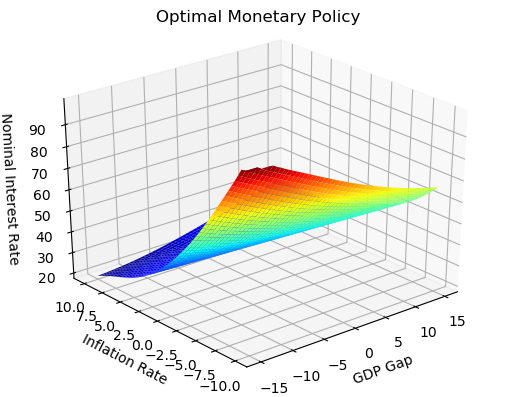

In [51]:
title = "Optimal Monetary Policy"
xlabel = "GDP Gap"
ylabel = "Inflation Rate"
zlabel = "Nominal Interest Rate"
PyPlot.surf(grids..., permutedims(reshape(X, grid_length...)), cmap=PyPlot.cm.jet)
ax = PyPlot.gca()
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.set_zlabel(zlabel)
ax.set_title(title, y=1.05)
ax.view_init(ax.elev, 230)

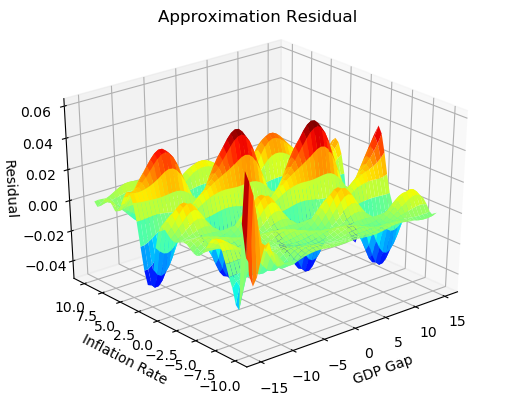

In [52]:
title = "Approximation Residual"
zlabel = "Residual"
PyPlot.surf(grids..., permutedims(reshape(resid, grid_length...)), cmap=PyPlot.cm.jet)
ax = PyPlot.gca()
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.set_zlabel(zlabel)
ax.set_title(title, y=1.05)
ax.view_init(ax.elev, 230)

### Simulation

In [53]:
N = 2
n_yrs = 20
n_paths = 5000
s_paths = Array{Float64}(undef, N, n_yrs+1, n_paths)
s_init = [15., 10.]
for i in 1:n_paths
    s_paths[:, :, i] = simulate(res, s_init, n_yrs+1)
end
mean_s_paths = [mean(s_paths[i, :, :], dims=2) for i in 1:N];

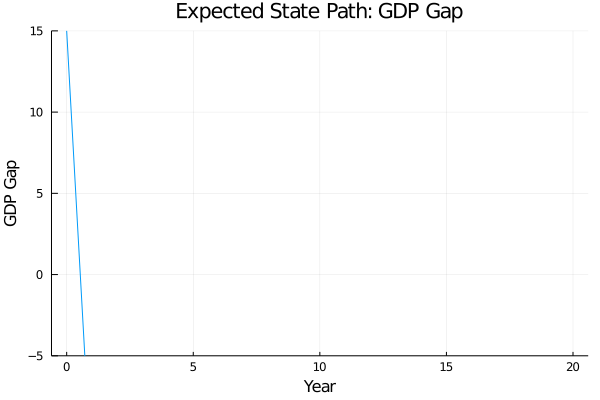

In [54]:
xlabel = "Year"
ylabel = "GDP Gap"
title = "Expected State Path: $ylabel"
plot(0:n_yrs, mean_s_paths[1], ylims=(-5, 15),
     title=title, xlabel=xlabel, ylabel=ylabel, label="")

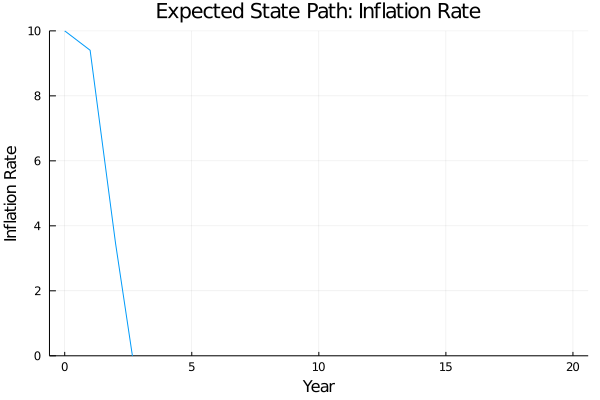

In [55]:
xlabel = "Year"
ylabel = "Inflation Rate"
title = "Expected State Path: $ylabel"
plot(0:n_yrs, mean_s_paths[2], ylims=(0, 10),
     title=title, xlabel=xlabel, ylabel=ylabel, label="")

## Production-Adjustment Model

In [56]:
alpha = 0.5
bet = 0.5
kappa = 0.5
sigma = 0.4
discount = 0.9;

In [57]:
prod_cost(q::Float64) = kappa * q
adj_cost(dq::Float64) = 0.5 * alpha * dq^2
f(s::Vector{Float64}, x::Float64) =
    s[1] * x^(1-bet) - prod_cost(x) - adj_cost(x - s[2])
g(s::Vector{Float64}, x::Float64, e::Float64) = [e, x]
x_lb(s) = 0.
x_ub(s) = 100;

In [58]:
n_shocks = 3
shocks, weights = qnwlogn(n_shocks, -sigma^2/2, sigma^2)  # See Errata

([0.46170906161702985, 0.9231163463866358, 1.8456293363222578], [0.16666666666666674, 0.6666666666666666, 0.16666666666666674])

In [59]:
n = [15, 10]
x_star = ((1 - bet) / kappa)^(1/bet)
s_min = [shocks[1], x_star - 1]
s_max = [shocks[end], x_star + 3]
basis = Basis(map(ChebParams, n, s_min, s_max)...)

2 dimensional Basis on the hypercube formed by (0.46170906161702985, 0.0) × (1.8456293363222578, 4.0).
Basis families are Cheb × Cheb


In [60]:
cdp = ContinuousDP(f, g, discount, shocks, weights, x_lb, x_ub, basis)

ContinuousDP{2,Array{Float64,1},Array{Float64,2},typeof(f),typeof(g),typeof(x_lb),typeof(x_ub)}(f, g, 0.9, [0.46170906161702985, 0.9231163463866358, 1.8456293363222578], [0.16666666666666674, 0.6666666666666666, 0.16666666666666674], x_lb, x_ub, ContinuousDPs.Interp{2,Array{Float64,2},Array{Float64,2},LU{Float64,Array{Float64,2}}}(2 dimensional Basis on the hypercube formed by (0.46170906161702985, 0.0) × (1.8456293363222578, 4.0).
Basis families are Cheb × Cheb
, [0.46549969165043137 0.02462331880972446; 0.49557600132395074 0.02462331880972446; … ; 1.8117623966153367 3.9753766811902755; 1.841838706288856 3.9753766811902755], ([0.46549969165043137, 0.49557600132395074, 0.5544141416161106, 0.6394426034594216, 0.7469452350595032, 0.8722236555605718, 1.0098025968341728, 1.1536691989696437, 1.2975358011051146, 1.4351147423787156, 1.5603931628797842, 1.6678957944798656, 1.7529242563231768, 1.8117623966153367, 1.841838706288856], [0.02462331880972446, 0.2179869516232642, 0.5857864376269049, 

### Value iteration

In [61]:
res = solve(cdp, VFI);

Compute iterate 50 with error 0.0029795551247104868
Compute iterate 100 with error 1.5355957328822e-5
Compute iterate 150 with error 7.914115496276963e-8
Compute iterate 166 with error 1.4665011427439367e-8
Converged in 166 steps


In [62]:
s_min, s_max = cdp.interp.lb, cdp.interp.ub
grid_length = collect(cdp.interp.size) * 5
grids = [range(s_min[i], stop=s_max[i], length=grid_length[i]) for i in 1:2]
set_eval_nodes!(res, grids...)
V, X, resid = res.V, res.X, res.resid;

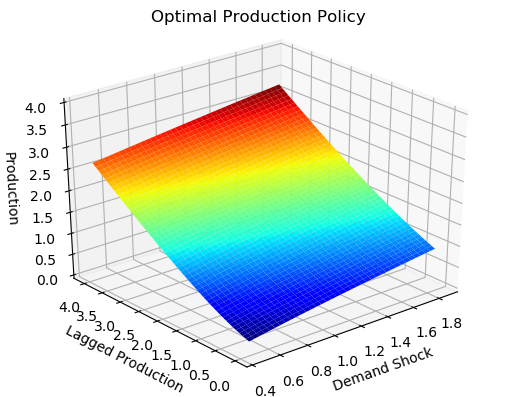

In [63]:
title = "Optimal Production Policy"
xlabel = "Demand Shock"
ylabel = "Lagged Production"
zlabel = "Production"
zlims = (0, 4)
PyPlot.surf(grids..., permutedims(reshape(X, grid_length...)), cmap=PyPlot.cm.jet)
ax = PyPlot.gca()
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.set_zlabel(zlabel)
ax.set_zlim(zlims)
ax.set_title(title, y=1.05)
ax.view_init(ax.elev, 230)

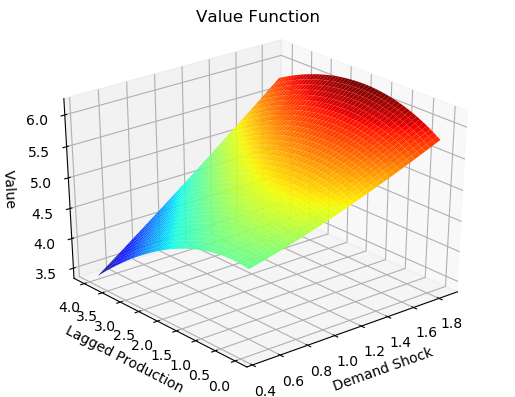

In [64]:
title = "Value Function"
zlabel = "Value"
PyPlot.surf(grids..., permutedims(reshape(V, grid_length...)), cmap=PyPlot.cm.jet)
ax = PyPlot.gca()
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.set_zlabel(zlabel)
ax.set_title(title, y=1.05)
ax.view_init(ax.elev, 230)

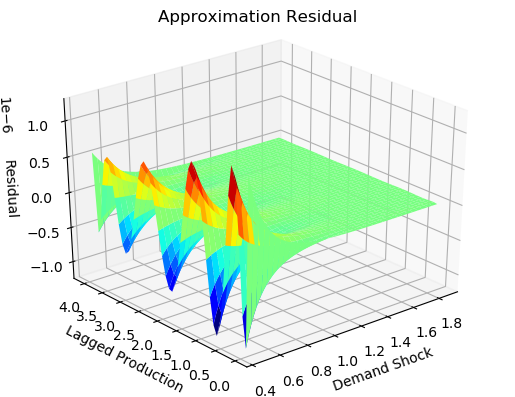

In [65]:
title = "Approximation Residual"
zlabel = "Residual"
PyPlot.surf(grids..., permutedims(reshape(resid, grid_length...)), cmap=PyPlot.cm.jet)
ax = PyPlot.gca()
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.set_zlabel(zlabel)
ax.set_title(title, y=1.05)
ax.view_init(ax.elev, 230)
ax.ticklabel_format(style="sci", axis="z", scilimits=(0,0))

### Policy iteration

In [66]:
res = solve(cdp, PFI);

Compute iterate 5 with error 6.671274643821334e-12
Converged in 5 steps


In [67]:
set_eval_nodes!(res, grids...)
V, X, resid = res.V, res.X, res.resid;

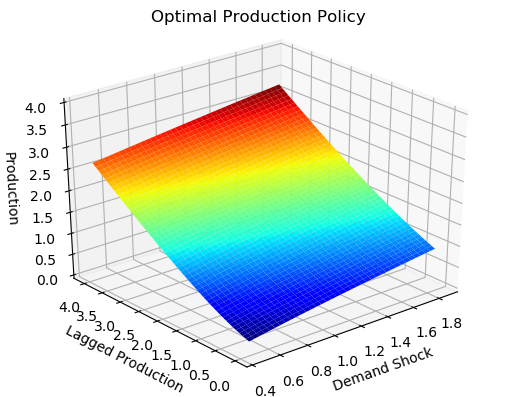

In [68]:
title = "Optimal Production Policy"
xlabel = "Demand Shock"
ylabel = "Lagged Production"
zlabel = "Production"
zlims = (0, 4)
PyPlot.surf(grids..., permutedims(reshape(X, grid_length...)), cmap=PyPlot.cm.jet)
ax = PyPlot.gca()
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.set_zlabel(zlabel)
ax.set_zlim(zlims)
ax.set_title(title, y=1.05)
ax.view_init(ax.elev, 230)

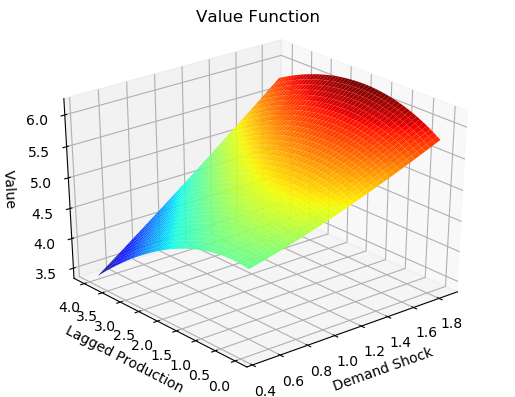

In [69]:
title = "Value Function"
zlabel = "Value"
PyPlot.surf(grids..., permutedims(reshape(V, grid_length...)), cmap=PyPlot.cm.jet)
ax = PyPlot.gca()
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.set_zlabel(zlabel)
ax.set_title(title, y=1.05)
ax.view_init(ax.elev, 230)

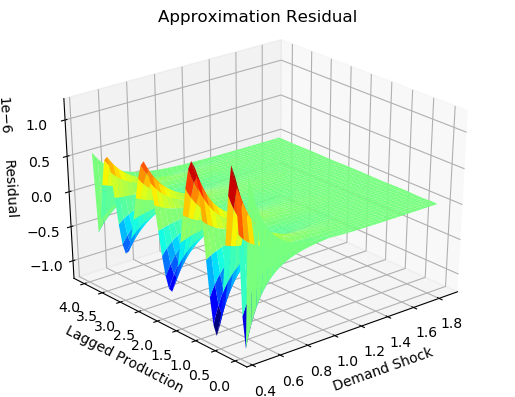

In [70]:
title = "Approximation Residual"
zlabel = "Residual"
PyPlot.surf(grids..., permutedims(reshape(resid, grid_length...)), cmap=PyPlot.cm.jet)
ax = PyPlot.gca()
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.set_zlabel(zlabel)
ax.set_title(title, y=1.05)
ax.view_init(ax.elev, 230)
ax.ticklabel_format(style="sci", axis="z", scilimits=(0,0))

### Simulation

In [71]:
n_yrs = 20
n_paths = 5000
s_paths = Array{Float64}(undef, ndims(cdp), n_yrs+1, n_paths)
q_init = 0.3
d_rv = DiscreteRV(cdp.weights)
for i in 1:n_paths
    s_init = [cdp.shocks[rand(d_rv)], q_init]
    s_paths[:, :, i] = simulate(res, s_init, n_yrs+1)
end
mean_q_path = mean(s_paths[2, :, :], dims=2);

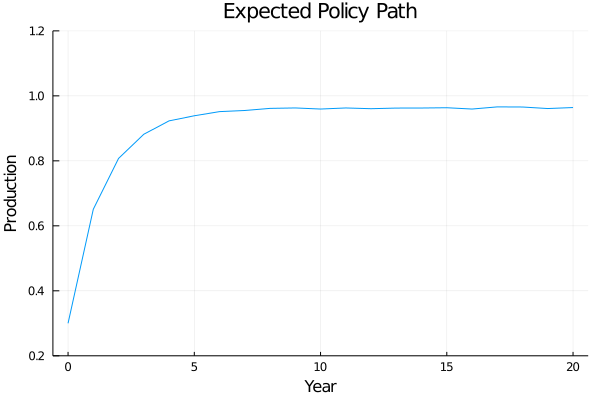

In [72]:
title = "Expected Policy Path"
xlabel = "Year"
ylabel = "Production"
plot(0:n_yrs, mean_q_path, ylims=(0.2, 1.2),
     title=title, xlabel=xlabel, ylabel=ylabel, label="")